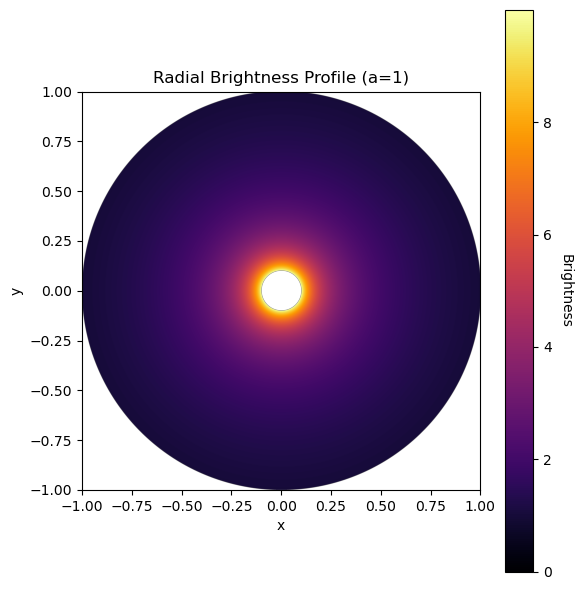

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
#Accretion Disc Model: Week 3

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ----- INITIALISE -----
Rmax = 1
Rmin = 0.1
N = 5000
eps = 1e-12

coords = np.linspace(-Rmax, Rmax, N)     # 1D coordinate vector
X, Y = np.meshgrid(coords, coords)       # 2D grid
R = np.hypot(X, Y)                       # distances from origin
theta = np.arctan2(Y, X)                 # angles from origin
mask = (R >= Rmin) & (R <= Rmax)         # points within the disc
extent = [-Rmax, Rmax, -Rmax, Rmax]      # CHAT - imshow extent for plotting

# ----- PROFILE FUNCTION -----
def profile2d(func, R, theta, mask,
              eps=1e-15,
              plot=False,
              colourmap="viridis",
              vmin=None, vmax=None,
              title="Profile",
              x_label="x", y_label="y",
              colour_bar_name="Value",
              extent=None,
              ax=None,
              symmetric=False,   # set symmetric color limits around 0 (for signed fields)
              nonneg=False       # force vmin=0 and vmax=max (for non-negative fields)
              ):
    """
    Compute a 2D profile from func(r, theta) on the masked domain, optionally plot it.
    """
    # Compute values
    values = np.full_like(R, np.nan, dtype=float)
    values[mask] = func(np.maximum(R[mask], eps), theta[mask])

    # Handle extent - CHAT
    if extent is None:
        # Fallback: infer square extent from max radius in mask
        rmax = np.nanmax(R[mask])
        extent = [-rmax, rmax, -rmax, rmax]

    # Auto color scaling helpers - CHAT
    if symmetric:
        vmax_auto = np.nanmax(np.abs(values))
        vmin_plot = -vmax_auto if vmin is None else vmin
        vmax_plot =  vmax_auto if vmax is None else vmax
    elif nonneg:
        vmin_plot = 0.0 if vmin is None else vmin
        vmax_plot = np.nanmax(values) if vmax is None else vmax
    else:
        vmin_plot = vmin
        vmax_plot = vmax

    # Optional plotting
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        else:
            fig = ax.figure

        img = ax.imshow(
            values,
            extent=extent,
            origin="lower",
            cmap=colourmap,
            aspect="equal",
            vmin=vmin_plot, vmax=vmax_plot
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label(colour_bar_name, rotation=270, labelpad=15)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        plt.tight_layout()
        plt.show()

    return values

# ----- CREATE PROFILES -----

# Velocity-like profile: cos(t)/sqrt(r), signed -> use symmetric=True
velocity = profile2d(
    lambda r, t: np.cos(t) / np.sqrt(r),
    R, theta, mask,
    eps=eps,
    plot=0,
    colourmap="seismic",
    title="Doppler Shift",
    colour_bar_name="Velocity",
    extent=extent,
    symmetric=True
)

# Radial Brightness profile: r^(-a), non-negative -> use nonneg=True
a = 1
brightnessrad = profile2d(
    lambda r, th: r**(-a),
    R, theta, mask,
    eps=eps,
    plot=1,
    colourmap="inferno",
    title=f"Radial Brightness Profile (a={a})",
    colour_bar_name="Brightness",
    extent=extent,
    nonneg=True
)

# ----- DATA ANALYSIS -----

# Parameters
p = 3  # decimal places

# Extract net freq and brightness
frequency = np.round(velocity, p) # discretise by rounding
brightness = brightnessrad

# Keep valid points
valid = np.isfinite(frequency) & np.isfinite(brightness)
f = frequency[valid]
w = brightness[valid]

# Group by unique rounded frequency and sum brightness
unique_f, inverse = np.unique(f, return_inverse=True)
sum_brightness = np.bincount(inverse, weights=w)
# Result: unique_f (frequencies), sum_brightness (total brightness per frequency)

# Normalise area to to 1
sum_brightness_norm = sum_brightness / np.sum(sum_brightness)

# ----- SMAK ANALYTICAL SOLUTION -----

def I(a, x):
    x = np.asarray(x, dtype=float)
    y = np.full_like(x, np.nan)

    # Domain: only compute where |x| <= 1
    dom = np.abs(x) <= 1
    xd = x[dom]
    s = np.sqrt(1.0 - xd**2)

    if a == 0.0:
        y[dom] = -((xd**3)/4.0 + (3.0*xd)/8.0) * s + (3.0/8.0) * np.arcsin(xd)
    elif a == 0.5:
        y[dom] = (1.0/3.0) * (s**3) - s
    elif a == 1.0:
        y[dom] = -(xd/2.0) * s + 0.5 * np.arcsin(xd)
    elif a == 1.5:
        y[dom] = -s
    elif a == 2.0:
        y[dom] = np.arcsin(xd)
    elif a == 2.5:
        # singular at x = 0 → leave as NaN there
        nz = (xd != 0)
        y_partial = np.full_like(xd, np.nan)
        y_partial[nz] = np.log(np.abs((1.0 - s[nz]) / xd[nz]))
        y[dom] = y_partial
    else:
        raise NotImplementedError("Only a ∈ {0, 0.5, 1, 1.5, 2, 2.5} is supported.")

    return y

def F(x, a, Rmin):

    x = np.asarray(x, dtype=float)
    y = np.full_like(x, np.nan)

    x_z = min(x, 1)
    x_1 = x*Rmin**0.5

    y = x**(2*a-5)*(I(a, x_z) - I(a, x_1))

    return y

Smak_x = np.linspace(-1.0, 1.0, 1000)

Smak_y = F(x = Smak_x, a = a, Rmin = 0.1)

# Aarea under Smak curve = area under numerical solution over same domain
Smak_y_norm = Smak_y / np.sum(sum_brightness)

# ----- PLOT SPECTRUM -----

def plot_spectrum(unique_f, sum_brightness_norm, p=3, xlim=(-5, 5), Smak = 0, sigma=None,
                  xlabel="Frequency)", ylabel="Brightness",
                  title="Light Spectrum", figsize=(8, 5), grid_alpha=0.3):
    
    #Plot frequency spectrum as a line graph, with optional Gaussian smoothing.

    # Make safe copies - CHAT
    x = np.asarray(unique_f)
    y = np.asarray(sum_brightness_norm)

    # Optional guassian smoothing
    if sigma is not None and sigma > 0:
        y = gaussian_filter1d(y, sigma=sigma)
        title = f"{title} (Gaussian Smoothed, sigma={sigma})"

    # Plot
    plt.figure(figsize=figsize)

    if Smak == True:
        plt.plot(Smak_x, Smak_y_norm, linestyle='-', linewidth=5, color='red', label='Smak Solution')
        plt.plot(x, y, linestyle='-', color='blue', label='Model Spectrum')
    else:
        plt.plot(x, y, color='blue', linestyle='-') 

    plt.xlabel(f"{xlabel} (rounded to {p} dp)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=grid_alpha)
    plt.tight_layout()
    if xlim is not None:
        plt.xlim(*xlim)
    plt.show()

# Raw spectrum (no smoothing)
plot_spectrum(
    unique_f, sum_brightness_norm, p=p,
    sigma=None, Smak=1, title="Light Spectrum"
)

# Smoothed spectrum (σ=10)
plot_spectrum(unique_f, sum_brightness_norm, p=p, sigma=100, Smak=1,
              title="Light Spectrum")


In [ ]:
# Linear Brightness profile: Rmax + rcos(th), non-negative -> use nonneg=True
brightnesslin = profile2d(
    lambda r, th: Rmax +r*np.cos(th),
    R, theta, mask,
    eps=eps,
    plot=False,
    colourmap="inferno",
    title=f"Linear Brightness Profile",
    colour_bar_name="Brightness",
    extent=extent,
    nonneg=True
)